<a href="https://colab.research.google.com/github/DavidMartinez16/Skin-Cancer-CNN/blob/master/Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Convolutional Neural Network Using Transfer Learning**

Import libraries

In [ ]:
import sys
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import itertools
import numpy as np

Define some functions which will be use later

In [ ]:
# Función para la nueva red
def modelo(clases):
    vgg = applications.vgg16.VGG16()
    cnn = Sequential()
    for capa in vgg.layers:
        cnn.add(capa)
    cnn.pop()
    for layer in cnn.layers:
        layer.trainable = False 
    cnn.add(Dense(clases, activation='softmax'))

    return cnn

In [ ]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    
    plt.show()

def print_results(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fn = cm[0, 1]
    fp = cm[1, 0]
    
    acc = ((tp + tn) / (tp + tn + fp + fn)) * 100
    
    sen = (tp / (tp + fn)) * 100
    
    spe = (tn / ( tn + fp )) * 100
    
    print ('Accuracy: ',  acc)

    print ('Sensitivity: ', sen)
    
    print ('Sensibility: ',  spe)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Define the path of the files

In [ ]:
K.clear_session()

data_train = '/content/drive/My Drive/Skin Cancer/data/train'
data_validation = '/content/drive/My Drive/Skin Cancer/data/test'


In [ ]:
epocas = 80
altura, longitud = 224, 224 # Tamaño a procesar las imágenes
batch_size = 32 # Número de imágenes a mandar en cada época
pasos_epoca = 1000
pasos_validacion = 20
# Tamaños de los filtros
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3,3)
tamano_filtro2 = (2,2)
tamano_pool = (2,2)
clases = 2
lr = 0.0005 

In [ ]:
len(data_train)/batch_size

1.4375

Generate sevaral images with different features

In [ ]:
entrenamiento_datagen = ImageDataGenerator(
    rescale=1./255, # Reescalar valores de pixeles de 0 a 1
    shear_range = 0.3, # Inclina las imágenes
    zoom_range = 0.3, # Añade zoom a las imágenes
    horizontal_flip = True # Invierte las imágenes, direccionalidad
)

validacion_datagen = ImageDataGenerator(
    rescale=1./255,
)


Access to the path and transform each image in the folder

In [ ]:
# Entra al directoria de training
imagen_train = entrenamiento_datagen.flow_from_directory(
    data_train,
    target_size= (altura, longitud),
    batch_size = batch_size,
    class_mode = 'categorical'
)

imagen_validation = validacion_datagen.flow_from_directory(
    data_validation,
    target_size= (altura, longitud),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 4084 images belonging to 2 classes.
Found 724 images belonging to 2 classes.


Create the Neural Network

In [ ]:
cnn = modelo(2)
cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr),
            metrics =['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7) 


553467904/553467096 [==============================] - 17s 0us/step


Structure of the Neural Network

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

Fit

In [ ]:
history =cnn.fit(imagen_train, steps_per_epoch=(4084/batch_size), epochs=epocas, validation_data = imagen_validation, 
                 validation_steps = (724/batch_size))

Epoch 1/80
128/127 [==============================] - 3133s 24s/step - loss: 0.6370 - accuracy: 0.6330 - val_loss: 0.6030 - val_accuracy: 0.7044
Epoch 2/80
128/127 [==============================] - 84s 658ms/step - loss: 0.5685 - accuracy: 0.7179 - val_loss: 0.4932 - val_accuracy: 0.7597
Epoch 3/80
128/127 [==============================] - 82s 638ms/step - loss: 0.5559 - accuracy: 0.7226 - val_loss: 0.5327 - val_accuracy: 0.7555
Epoch 4/80
128/127 [==============================] - 80s 625ms/step - loss: 0.5388 - accuracy: 0.7395 - val_loss: 0.4980 - val_accuracy: 0.7707
Epoch 5/80
128/127 [==============================] - 80s 623ms/step - loss: 0.5301 - accuracy: 0.7468 - val_loss: 0.4929 - val_accuracy: 0.7818
Epoch 6/80
128/127 [==============================] - 79s 616ms/step - loss: 0.5350 - accuracy: 0.7390 - val_loss: 0.4990 - val_accuracy: 0.7831
Epoch 7/80
128/127 [==============================] - 79s 615ms/step - loss: 0.5057 - accuracy: 0.7620 - val_loss: 0.4935 - val_ac

Plot the training curves

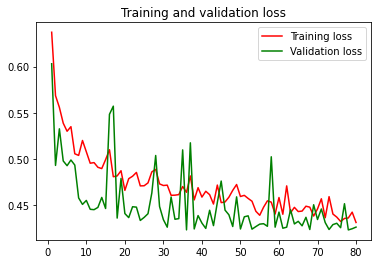

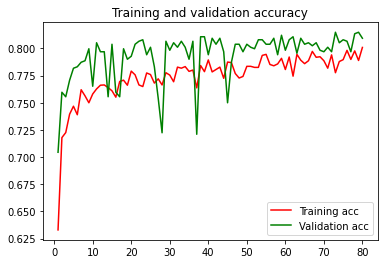

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training_curves(history)

Testing the model with the test images

In [ ]:
cnn.save('/content/drive/My Drive/modelo2/modelrl.h5')
cnn.save_weights('/content/drive/My Drive/modelo2/pesosrl.h5')

In [ ]:
data_test = '/content/drive/My Drive/Skin Cancer/data/real_test'

In [ ]:
# Transformo las imágenes de prueba
testing_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3, # Inclina las imágenes
    zoom_range = 0.3, # Añade zoom a las imágenes
    horizontal_flip = True # Invierte las imágenes, direccionalidad
)

imagen_test = testing_datagen.flow_from_directory(
    data_test,
    target_size=(altura, longitud),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_labels = imagen_test.classes

Found 146 images belonging to 2 classes.


In [ ]:
predictions = cnn.predict_generator(imagen_test, verbose = 1)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm

Instructions for updating:
Please use Model.predict, which supports generators.
5/5 [==============================] - 86s 17s/step


array([[36, 30],
       [38, 42]])

In [ ]:
print_results(cm)

Accuracy:  53.42465753424658
Sensitivity:  54.54545454545454
Sensibility:  52.5
